## OPTIONS

In [1]:
options(jupyter.plot_mimetypes = "image/svg+xml")

## IMPORTS

In [2]:
pacman::p_load( devtools,                                                   # utils
                colorout, crayon, colorspace, RColorBrewer,                 # coloring
                rlist,                                                      # working
                openxlsx, readr,                                            # IO
                ggplot2, grid, gridExtra,                                   # plotting
                lazyeval, tibble, dplyr, tidyr, magrittr, stringr, purrr )  # dplyr

In [3]:
load('clean.RData', verbose = TRUE)

Loading objects:
  msk.surface
  jpro.surface
  step.0


In [13]:
source('_keys.R')  # exclude.protein, compare.protein, pass.protein, picks, aml.additions

## VECTORS

In [14]:
pass.tissue <- c('bone', 'blood')

In [15]:
vital <- c(
'adipose tissue',
'adrenal',
'bladder',
'brain',
'bronchus',
'eye',
'gut',
'heart',
'kidney',
'laryngopharynx',
'liver',
'lung',
'nasopharynx',
'oropharynx',
'pancreas',
'rectum',
'skeletal muscle',
'skin',
'smooth muscle',
'soft tissue',
'spinal cord',
'stomach')

In [16]:
non.vital <- c(
'appendix',
'bone',
'blood',
'breast',
'cerumen',
'cervix',
'epididymis',
'fallopian tube',
'gallbladder',
'lymph node',
'ovary',
'parathyroid',
'prostate',
'seminal',
'spleen',
'synovial fluid',
'testis',
'thyroid',
'tonsil',
'uterus',
'vagina')

In [17]:
palette <- c(
'zero'   = '#202c99',
'low'    = '#fbeaea',
'medium' = '#e77e7e',
'high'   = '#c12525')

## FUNCTIONS

In [18]:
PlotTissue <- function(events, faceting = FALSE, pdf = FALSE, file.name = 'plot_tissue.pdf', width = 20, height = 10, order = TRUE) {

    if(order == TRUE) {
        events <-
            bind_rows(data_frame(
                gene = as.character(unlist(events[1,'gene'])),
                tissue = c('adipose tissue', 'adrenal', 'appendix', 'bladder', 'blood', 'bone', 'brain', 'breast', 'bronchus', 'cerumen', 'cervix', 'epididymis', 'eye', 'fallopian tube', 'gallbladder', 'gut', 'heart', 'kidney', 'laryngopharynx', 'liver', 'lung', 'lymph node', 'nasopharynx', 'oropharynx', 'ovary', 'pancreas', 'parathyroid', 'prostate', 'rectum', 'seminal', 'skeletal muscle', 'skin', 'smooth muscle', 'soft tissue', 'spinal cord', 'spleen', 'stomach', 'synovial fluid', 'testis', 'thyroid', 'tonsil', 'uterus', 'vagina'),
                level = NA), events) %>%
            mutate(gene = factor(gene, levels = unique(gene))) %>%
            mutate(tissue = factor(tissue, levels = c(vital, non.vital)))
    }

    if(all(na.omit(events$level) %% 1 == 0)) {  # check if integer, if so plot discrete
        events %<>%
            mutate(level =
                ifelse(level == 0, 'zero',
                ifelse(level == 1, 'low',
                ifelse(level == 2, 'medium',
                ifelse(level == 3, 'high',
                NA))))) %>%
            mutate(level = factor(level, levels = unique(level)))

        m.gg <-
            ggplot(events, aes(tissue, gene)) +
            geom_tile(aes(fill = level, drop = FALSE), colour = 'grey') +
            scale_fill_manual(
                breaks           = names(palette),
                values           = palette,
                na.value         = 'grey',
                drop             = FALSE,
                guide            = guide_legend(reverse = TRUE))
    } else {
        m.gg <-
            ggplot(events, aes(tissue, gene)) + 
            geom_tile(aes(fill = level), colour = 'grey') +
            scale_fill_gradientn(
                colours = palette,
                na.value = 'transparent',
                breaks = 0:3,
                labels = names(palette),
                limits = c(0, 3))
    }

    if(faceting == TRUE) {
        mt.gg <-
            m.gg +
            theme(
                text             = element_text(size = 10),
                axis.text.x      = element_text(angle = 90, vjust = 0.5, hjust = 1),
                panel.background = element_rect(fill = 'grey'),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.border     = element_rect(colour = 'black', fill = NA, size = 1),
                strip.background = element_blank(),
                strip.text.x     = element_blank()) +
            facet_wrap(~ split, ncol = 1, scales = 'free_y')
    } else {
        mt.gg <-
            m.gg +
            theme(
                text             = element_text(size = 10),
                axis.text.x      = element_text(angle = 90, vjust = 0.5, hjust = 1),
                panel.background = element_rect(fill = 'grey'),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.border     = element_rect(colour = 'black', fill = NA, size = 1))
    }

    if(pdf == TRUE) {
        pdf(file.name, width, height)
            plot(mt.gg)
        dev.off()
    } else {
        options(repr.plot.width = width, repr.plot.height = height)
        plot(mt.gg)
    }
}

## AML SURFACE POOL

In [19]:
msk.jpro.add <-
    c(msk.surface,   # from in-house biotinylation data
      jpro.surface,  # from jpro surface study
      aml.additions  # from literature
     ) %>%
    unique %>%
    sort

## CANDIDATE SELECTION

In [20]:
step.1 <-
    step.0 %>%
    filter(db.num >= 2) %>%
    filter(membrane == TRUE) %>%
    filter(ensembl.gene %in% msk.jpro.add) %>%
    arrange(gross.mean.abundance, hgnc)

In [21]:
step.1 %>%
select(-tissue.mean, -hpa, -pdb, -hpm, -rna) %>%
spread(tissue, tissue.max) %>%
unique %>%
head

hgnc     ensembl.gene    db.num gross.mean.abundance membrane fill      msk.0.09aml msk.0.kasum1 msk.0.molm13 msk.0.monomac ⋯ soft tissue
1 SLC22A13 ENSG00000172940 3      0.04166667           TRUE     0.9302326 NA          NA           NA           NA            ⋯ NA         
2 SLC22A13 ENSG00000172940 3      0.04166667           TRUE     0.9302326 NA          NA           NA           NA            ⋯  0         
3 GAGE1    ENSG00000205777 2      0.06250000           TRUE     0.9302326  0           0            0            0            ⋯ NA         
4 GAGE1    ENSG00000205777 2      0.06250000           TRUE     0.9302326  0           0            0            0            ⋯  0         
5 SLC2A9   ENSG00000109667 3      0.08333333           TRUE     0.9302326  1           0            0            0            ⋯ NA         
6 SLC2A9   ENSG00000109667 3      0.08333333           TRUE     0.9302326  1           0            0            0            ⋯  0         
  spinal cord spleen stomach synovial fluid testis thyroid tonsil uterus vagina
1 NA           0      0      NA              0      0       0      0     NA    
2  0          NA     NA      NA             NA     NA      NA     NA      0    
3 NA           0      0      NA              2      0       0      0     NA    
4  0          NA     NA      NA             NA     NA      NA     NA      0    
5 NA           0      0      NA              1      0       0      0     NA    
6  0          NA     NA      NA             NA     NA      NA     NA      0

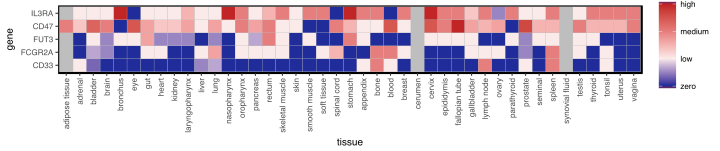

In [22]:
step.1 %>%
filter(hgnc %in% compare.protein) %>%
arrange(gross.mean.abundance) %>%
select(gene = hgnc, tissue, level = tissue.mean) %>%
PlotTissue(width = 10, height = 2.1)

Warning message:
“Ignoring unknown aesthetics: drop”

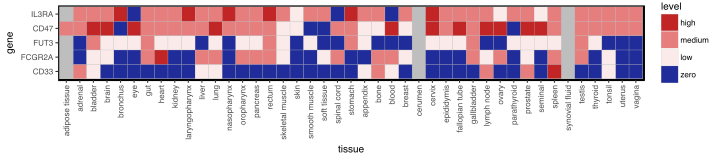

In [23]:
step.1 %>%
filter(hgnc %in% compare.protein) %>%
arrange(gross.mean.abundance) %>%
select(gene = hgnc, tissue, level = tissue.max) %>%
PlotTissue(width = 10, height = 2.2)

In [24]:
step.2 <-
    step.1 %>%
    filter(gross.mean.abundance < 1 | hgnc %in% pass.protein) %>%
    group_by(hgnc) %>%
    mutate(tissue.mean.round =
        ifelse(tissue.mean <  0.5, 0,
        ifelse(tissue.mean <  1.5, 1,
        ifelse(tissue.mean <  2.5, 2,
        ifelse(tissue.mean <= 3,   3,
            NA))))) %>%
    mutate(max.test = tissue.max < 3 | tissue %in% pass.tissue | hgnc %in% pass.protein) %>%
    filter(!any(na.omit(max.test) == FALSE) | hgnc %in% pass.protein) %>%
    mutate(aml.tot =
        any(!is.na(msk.0.09aml)   & msk.0.09aml   != 0) +
        any(!is.na(msk.0.kasum1)  & msk.0.kasum1  != 0) +
        any(!is.na(msk.0.molm13)  & msk.0.molm13  != 0) +
        any(!is.na(msk.0.monomac) & msk.0.monomac != 0) +
        any(!is.na(msk.0.tf)      & msk.0.tf      != 0) +
        any(!is.na(msk.0.thp1)    & msk.0.thp1    != 0) +
        any(!is.na(jpro.thp1)     & jpro.thp1     != 0)) %>%
    ungroup %>%
    arrange(gross.mean.abundance, ensembl.gene) %>%
    filter(!hgnc %in% exclude.protein) %>%
    arrange(gross.mean.abundance) %>%
    full_join(expand.grid(hgnc = unique(.$hgnc), tissue = unique(.$tissue), stringsAsFactors = FALSE),
              by = c('hgnc', 'tissue')) %>%
    mutate(group.n = as.integer(factor(hgnc, levels=unique(hgnc)))) %>%
    arrange(hgnc, tissue)

In [25]:
step.2 %>%
select(-tissue.mean, -hpa, -pdb, -hpm, -rna, -tissue.mean.round, -max.test) %>%
spread(tissue, tissue.max) %>%
filter(!is.na(ensembl.gene)) %>%
unique %>%
head

hgnc  ensembl.gene    db.num gross.mean.abundance membrane fill      msk.0.09aml msk.0.kasum1 msk.0.molm13 msk.0.monomac ⋯ soft tissue spinal cord
1 ABCC1 ENSG00000103222 3      0.7235772            TRUE     0.9534884  0           9            2            2            ⋯ NA          NA         
2 ABCC1 ENSG00000103222 3      0.7235772            TRUE     0.9534884  0           9            2            2            ⋯  2           1         
3 ABCC4 ENSG00000125257 3      0.4458333            TRUE     0.9302326  0           2            0            0            ⋯  0           2         
4 ABCC4 ENSG00000125257 3      0.4458333            TRUE     0.9302326  0           2            0            0            ⋯ NA          NA         
5 ABCD4 ENSG00000119688 3      0.5555556            TRUE     0.9069767 NA          NA           NA           NA            ⋯ NA          NA         
6 ABCD4 ENSG00000119688 3      0.5555556            TRUE     0.9069767 NA          NA           NA           NA            ⋯  1           0         
  spleen stomach synovial fluid testis thyroid tonsil uterus vagina
1  0      1      NA              2      0       1      1     NA    
2 NA     NA      NA             NA     NA      NA     NA      0    
3 NA     NA      NA             NA     NA      NA     NA      0    
4  1      0      NA              2      0       0      0     NA    
5  0      0      NA              2      0      NA      1     NA    
6 NA     NA      NA             NA     NA      NA     NA      0

In [26]:
step.2 %>%
filter(!hgnc %in% pass.protein) %>%
arrange(gross.mean.abundance) %>%
mutate(hgnc = factor(hgnc, levels = unique(hgnc))) %>%
select(gene = hgnc, tissue, level = tissue.mean) %>%
filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
PlotTissue(width = 10, height = 18.5)

In [27]:
step.2 %>%
filter(!hgnc %in% pass.protein) %>%
arrange(gross.mean.abundance) %>%
mutate(hgnc = factor(hgnc, levels = unique(hgnc))) %>%
select(gene = hgnc, tissue, level = tissue.max) %>%
filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
PlotTissue(width = 10, height = 18.5)

Warning message:
“Ignoring unknown aesthetics: drop”

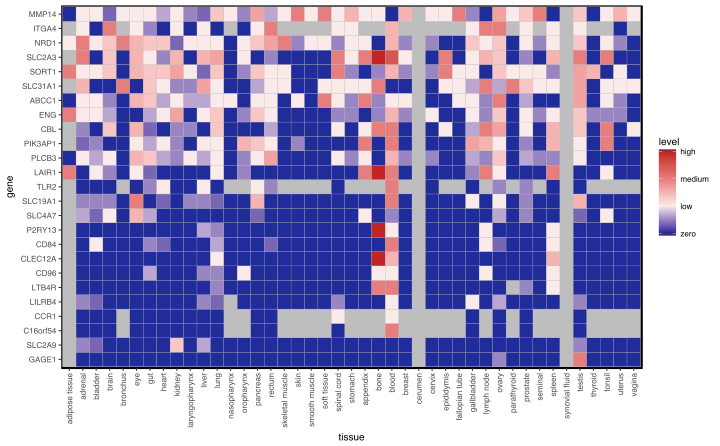

In [28]:
step.2 %>%
filter(ensembl.gene %in% picks) %>%
filter(!hgnc %in% pass.protein) %>%
arrange(gross.mean.abundance) %>%
mutate(hgnc = factor(hgnc, levels = unique(hgnc))) %>%
select(gene = hgnc, tissue, level = tissue.mean) %>%
filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
PlotTissue(width = 10, height = 6.2)

Warning message:
“Ignoring unknown aesthetics: drop”

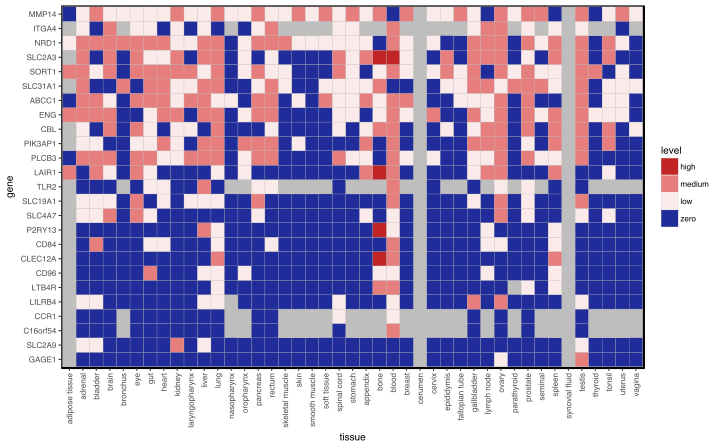

In [29]:
step.2 %>%
filter(ensembl.gene %in% picks) %>%
filter(!hgnc %in% pass.protein) %>%
arrange(gross.mean.abundance) %>%
mutate(hgnc = factor(hgnc, levels = unique(hgnc))) %>%
select(gene = hgnc, tissue, level = tissue.max) %>%
filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
PlotTissue(width = 10, height = 6.2)

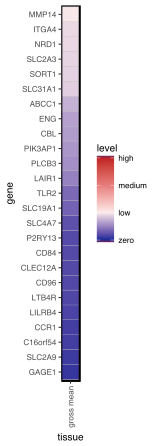

In [30]:
step.2 %>%
filter(ensembl.gene %in% picks) %>%
select(hgnc, gross.mean.abundance) %>%
arrange(gross.mean.abundance) %>%
mutate(hgnc = factor(hgnc, levels = unique(hgnc))) %>%
unique %>%
filter(!is.na(gross.mean.abundance)) %>%
mutate(tissue = 'gross mean') %>%
rename(gene = hgnc, level = gross.mean.abundance) %>%
PlotTissue(width = 2.2, height = 6.2, order = FALSE)

## COMBI

In [31]:
step.3 <-
    combn(1:length(unique(step.2$hgnc)), 2) %>%
    t %>%
    as_data_frame %>%
    set_names(c('a', 'b')) %>%
    mutate(pair.num = row_number()) %>%
    rowwise %>%
    do({
            x <- .
            bind_cols(
                step.2 %>% filter(group.n == x$a) %>% set_names(str_c(colnames(step.2), '_a')),
                step.2 %>% filter(group.n == x$b) %>% set_names(str_c(colnames(step.2), '_b'))
            ) %>%
            mutate(pair.num = x$pair.num) %>%
            select(pair.num, everything())
    }) %>%
    ungroup %>%
    filter(!is.na(ensembl.gene_a) & !is.na(ensembl.gene_b))

In [32]:
step.4 <-
    step.3 %>%
    rowwise %>%
    mutate(max.level.1 =
        tissue.max_a < 2 | is.na(tissue.max_a) | tissue.max_b < 2 | is.na(tissue.max_b)) %>%
    mutate(max.level.2 =
        (tissue_a %in% non.vital & (tissue.max_a < 2 | is.na(tissue.max_a) | tissue.max_b < 2 | is.na(tissue.max_b))) |
        (tissue_a %in% vital     & (tissue.max_a < 1 | is.na(tissue.max_a) | tissue.max_b < 1 | is.na(tissue.max_b))) ) %>%
    ungroup %>%
    select(-hpa_a, -hpa_b, -hpm_a, -hpm_b, -pdb_a, -pdb_b, -rna_a, -rna_b) %>%
    unique #%>%
#     gather(tissue_x, tissue, tissue_a:tissue_b) #%>%
#     gather(tissue.max_x, tissue.max, tissue.max_a:tissue.max_b) #%>%
#     filter(
#         (tissue_x == 'tissue_a' & tissue.max_x == 'tissue.max_a') |
#         (tissue_x == 'tissue_b' & tissue.max_x == 'tissue.max_b') ) #%>%
#     mutate(tissue_x =
#         ifelse(tissue_x == 'tissue_a', 'a',
#         ifelse(tissue_x == 'tissue_b', 'b',
#         NA))) %>%
    #mutate(gross.mean.abundance = ifelse(tissue_x == 'a', gross.mean.abundance_a, gross.mean.abundance_b)) %>%
    #mutate(hgnc = ifelse(tissue_x == 'a', hgnc_a, hgnc_b)) %>%
    #select(pair.num, pair = tissue_x, hgnc, tissue, tissue.max, gross.mean.abundance, max.level.1, max.level.2) %>%
    #unique

In [ ]:
print(step.4)

In [ ]:
step.4.level.1 <-
    step.4 %>%
    group_by(pair.num) %>%
    filter(all(max.level.1 == TRUE)) %>%
    mutate(order = mean(gross.mean.abundance)) %>%
    ungroup %>%
    arrange(order) %>%
    #filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
    mutate(pair.num = factor(pair.num, levels = unique(pair.num))) %>%
    mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
    group_by(pair.num) %>%
    mutate(pass.test = !hgnc %in% pass.protein) %>%
    filter(any(pass.test == TRUE)) %>%
    select(split = pair.num, gene = hgnc, tissue, level = tissue.max) %>%
    filter(!is.na(level))

In [ ]:
step.4.level.1 %>% PlotTissue(facet = TRUE, width = 10, height = 400)

In [ ]:
step.4.level.2 <-
    step.4 %>%
    group_by(pair.num) %>%
    filter(all(max.level.2 == TRUE)) %>%
    mutate(order = mean(gross.mean.abundance)) %>%
    ungroup %>%
    arrange(order) %>%
    #filter(!tissue %in% c('cerumen', 'synovial fluid')) %>%
    mutate(pair.num = factor(pair.num, levels = unique(pair.num))) %>%
    mutate(tissue = factor(tissue, levels = c(vital, non.vital))) %>%
    group_by(pair.num) %>%
    mutate(pass.test = !hgnc %in% pass.protein) %>%
    filter(any(pass.test == TRUE)) %>%
    select(split = pair.num, gene = hgnc, tissue, level = tissue.max) %>%
    filter(!is.na(level))

In [1]:
step.4.level.2 %>% PlotTissue(facet = TRUE, width = 10, height = 80)

ERROR: Error in eval(expr, envir, enclos): could not find function "%>%"


In [5]:
nrow(step.0)

[1] 752188